<a href="https://colab.research.google.com/github/RyosukeHanaoka/flask_deploy/blob/main/ViT_crp0_3_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/crp>0.3/image_crp0.3_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 6.3 MB/s eta 0:00:00


In [3]:
batch_size=16 #バッチサイズ(batch size)
epochs = 120
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size // 4,  # 実際のバッチサイズを小さくする
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
#pprint(model_names)
#model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

学習ループを設定し、実行していく

In [4]:
import gc
from torchvision.utils import make_grid

# メモリ最適化の環境変数設定
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-4-f9a2aeb43fb6>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/48 [00:00<?, ?it/s]

<ipython-input-4-f9a2aeb43fb6>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 1 - loss : 8.4319 - acc: 0.4479 - val_loss : 0.8705 - val_acc: 0.6250 - test_loss : 0.8711 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1947 - acc: 0.4740 - val_loss : 0.6659 - val_acc: 0.6250 - test_loss : 0.6669 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7612 - acc: 0.5781 - val_loss : 0.6645 - val_acc: 0.6250 - test_loss : 0.6658 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7445 - acc: 0.5469 - val_loss : 0.6647 - val_acc: 0.6250 - test_loss : 0.6658 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6888 - acc: 0.6094 - val_loss : 0.6618 - val_acc: 0.6250 - test_loss : 0.6630 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6830 - acc: 0.5833 - val_loss : 0.6729 - val_acc: 0.6250 - test_loss : 0.6744 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7324 - acc: 0.5573 - val_loss : 0.6582 - val_acc: 0.6250 - test_loss : 0.6602 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6994 - acc: 0.5938 - val_loss : 0.9482 - val_acc: 0.3750 - test_loss : 0.9508 - test_acc: 0.3750



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.8232 - acc: 0.4531 - val_loss : 0.7891 - val_acc: 0.6250 - test_loss : 0.7924 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.7459 - acc: 0.5729 - val_loss : 0.6573 - val_acc: 0.6250 - test_loss : 0.6611 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7080 - acc: 0.5365 - val_loss : 0.7958 - val_acc: 0.6250 - test_loss : 0.8001 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.7696 - acc: 0.5156 - val_loss : 0.7023 - val_acc: 0.6250 - test_loss : 0.7072 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.8107 - acc: 0.5000 - val_loss : 0.6537 - val_acc: 0.6250 - test_loss : 0.6584 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6977 - acc: 0.5677 - val_loss : 0.6861 - val_acc: 0.6250 - test_loss : 0.6910 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.7127 - acc: 0.5573 - val_loss : 0.6572 - val_acc: 0.6250 - test_loss : 0.6620 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6880 - acc: 0.5573 - val_loss : 0.6518 - val_acc: 0.6250 - test_loss : 0.6569 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6718 - acc: 0.5990 - val_loss : 0.6516 - val_acc: 0.6250 - test_loss : 0.6562 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.7175 - acc: 0.5729 - val_loss : 0.6539 - val_acc: 0.6250 - test_loss : 0.6602 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6920 - acc: 0.5521 - val_loss : 0.6526 - val_acc: 0.6250 - test_loss : 0.6601 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6868 - acc: 0.5833 - val_loss : 0.6518 - val_acc: 0.6250 - test_loss : 0.6593 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.7594 - acc: 0.5052 - val_loss : 0.7142 - val_acc: 0.6250 - test_loss : 0.7208 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.7425 - acc: 0.5365 - val_loss : 0.6526 - val_acc: 0.6250 - test_loss : 0.6580 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6792 - acc: 0.5573 - val_loss : 0.6540 - val_acc: 0.6250 - test_loss : 0.6610 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6893 - acc: 0.5990 - val_loss : 0.6504 - val_acc: 0.6250 - test_loss : 0.6589 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6896 - acc: 0.5990 - val_loss : 0.7480 - val_acc: 0.6250 - test_loss : 0.7571 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6847 - acc: 0.5781 - val_loss : 0.6522 - val_acc: 0.6250 - test_loss : 0.6599 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6773 - acc: 0.5937 - val_loss : 0.6417 - val_acc: 0.6250 - test_loss : 0.6529 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.7495 - acc: 0.5365 - val_loss : 0.6509 - val_acc: 0.6250 - test_loss : 0.6613 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6959 - acc: 0.6146 - val_loss : 0.7302 - val_acc: 0.3750 - test_loss : 0.7427 - test_acc: 0.3750



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.7001 - acc: 0.5313 - val_loss : 0.6401 - val_acc: 0.6250 - test_loss : 0.6527 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6880 - acc: 0.6042 - val_loss : 0.7332 - val_acc: 0.3750 - test_loss : 0.7510 - test_acc: 0.3750



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.7037 - acc: 0.4948 - val_loss : 0.6856 - val_acc: 0.5000 - test_loss : 0.7041 - test_acc: 0.5000



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6788 - acc: 0.6146 - val_loss : 0.6432 - val_acc: 0.8036 - test_loss : 0.6670 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6443 - acc: 0.6146 - val_loss : 0.6093 - val_acc: 0.6429 - test_loss : 0.6310 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6393 - acc: 0.6562 - val_loss : 0.6096 - val_acc: 0.6250 - test_loss : 0.6505 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6219 - acc: 0.6146 - val_loss : 0.6079 - val_acc: 0.6964 - test_loss : 0.6538 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6100 - acc: 0.6510 - val_loss : 0.5260 - val_acc: 0.7500 - test_loss : 0.5491 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5852 - acc: 0.7292 - val_loss : 0.5081 - val_acc: 0.7500 - test_loss : 0.5049 - test_acc: 0.8750



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5397 - acc: 0.7708 - val_loss : 0.7394 - val_acc: 0.5357 - test_loss : 0.7864 - test_acc: 0.5000



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5687 - acc: 0.6771 - val_loss : 0.5550 - val_acc: 0.7857 - test_loss : 0.5806 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6650 - acc: 0.6406 - val_loss : 0.5262 - val_acc: 0.6429 - test_loss : 0.5201 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5622 - acc: 0.6875 - val_loss : 0.4597 - val_acc: 0.7679 - test_loss : 0.5052 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6005 - acc: 0.6719 - val_loss : 0.7021 - val_acc: 0.6607 - test_loss : 0.6929 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6125 - acc: 0.6979 - val_loss : 0.5566 - val_acc: 0.6964 - test_loss : 0.5633 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5801 - acc: 0.6667 - val_loss : 0.4922 - val_acc: 0.7500 - test_loss : 0.5143 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5859 - acc: 0.6771 - val_loss : 0.4933 - val_acc: 0.8036 - test_loss : 0.5194 - test_acc: 0.7500



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5426 - acc: 0.7812 - val_loss : 0.4541 - val_acc: 0.7857 - test_loss : 0.4843 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.4964 - acc: 0.7917 - val_loss : 0.4645 - val_acc: 0.7321 - test_loss : 0.5299 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5085 - acc: 0.7500 - val_loss : 0.4781 - val_acc: 0.7143 - test_loss : 0.5280 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5247 - acc: 0.7083 - val_loss : 0.4413 - val_acc: 0.8036 - test_loss : 0.4425 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5391 - acc: 0.7656 - val_loss : 0.7019 - val_acc: 0.6786 - test_loss : 0.8467 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5189 - acc: 0.7656 - val_loss : 0.4335 - val_acc: 0.8036 - test_loss : 0.5344 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5415 - acc: 0.7396 - val_loss : 0.4439 - val_acc: 0.7500 - test_loss : 0.4840 - test_acc: 0.7500



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5051 - acc: 0.7448 - val_loss : 0.4595 - val_acc: 0.7321 - test_loss : 0.5075 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5131 - acc: 0.7240 - val_loss : 0.4971 - val_acc: 0.7143 - test_loss : 0.5578 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5606 - acc: 0.6823 - val_loss : 0.5126 - val_acc: 0.7143 - test_loss : 0.5534 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5592 - acc: 0.7188 - val_loss : 0.5115 - val_acc: 0.7321 - test_loss : 0.5586 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5077 - acc: 0.7760 - val_loss : 0.4574 - val_acc: 0.8036 - test_loss : 0.4988 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.4877 - acc: 0.7656 - val_loss : 0.5303 - val_acc: 0.6964 - test_loss : 0.6279 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.4934 - acc: 0.7604 - val_loss : 0.5493 - val_acc: 0.7143 - test_loss : 0.6709 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5090 - acc: 0.7500 - val_loss : 0.4576 - val_acc: 0.8036 - test_loss : 0.5286 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5290 - acc: 0.7083 - val_loss : 0.4389 - val_acc: 0.7500 - test_loss : 0.4929 - test_acc: 0.7500



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5396 - acc: 0.7344 - val_loss : 0.5025 - val_acc: 0.8036 - test_loss : 0.5670 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5011 - acc: 0.7500 - val_loss : 0.4398 - val_acc: 0.7857 - test_loss : 0.4695 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.4764 - acc: 0.7917 - val_loss : 0.4573 - val_acc: 0.7679 - test_loss : 0.4925 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5045 - acc: 0.7656 - val_loss : 0.5781 - val_acc: 0.7321 - test_loss : 0.6919 - test_acc: 0.6250



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5559 - acc: 0.7344 - val_loss : 0.4473 - val_acc: 0.7679 - test_loss : 0.4919 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5011 - acc: 0.7396 - val_loss : 0.4452 - val_acc: 0.8036 - test_loss : 0.4777 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5164 - acc: 0.7396 - val_loss : 0.4735 - val_acc: 0.7679 - test_loss : 0.5184 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5243 - acc: 0.7448 - val_loss : 0.5366 - val_acc: 0.6964 - test_loss : 0.5821 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5378 - acc: 0.6927 - val_loss : 0.4533 - val_acc: 0.8214 - test_loss : 0.4705 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.4864 - acc: 0.7760 - val_loss : 0.5278 - val_acc: 0.7143 - test_loss : 0.5716 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.4879 - acc: 0.7917 - val_loss : 0.4481 - val_acc: 0.7857 - test_loss : 0.4791 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.4839 - acc: 0.7604 - val_loss : 0.4514 - val_acc: 0.7679 - test_loss : 0.5168 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5158 - acc: 0.7604 - val_loss : 0.4337 - val_acc: 0.7857 - test_loss : 0.4690 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5043 - acc: 0.7240 - val_loss : 0.4204 - val_acc: 0.8571 - test_loss : 0.4718 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5505 - acc: 0.6979 - val_loss : 0.6395 - val_acc: 0.6964 - test_loss : 0.6829 - test_acc: 0.5938



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.4836 - acc: 0.7917 - val_loss : 0.4280 - val_acc: 0.8036 - test_loss : 0.4200 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.4860 - acc: 0.7500 - val_loss : 0.5420 - val_acc: 0.7143 - test_loss : 0.5743 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.4784 - acc: 0.7396 - val_loss : 0.4152 - val_acc: 0.8036 - test_loss : 0.4425 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.4576 - acc: 0.7917 - val_loss : 0.4960 - val_acc: 0.7143 - test_loss : 0.5357 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.4327 - acc: 0.8073 - val_loss : 0.4083 - val_acc: 0.8214 - test_loss : 0.4308 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.4576 - acc: 0.7604 - val_loss : 0.4158 - val_acc: 0.7679 - test_loss : 0.4539 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.4714 - acc: 0.7760 - val_loss : 0.5124 - val_acc: 0.7321 - test_loss : 0.6035 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.5029 - acc: 0.7656 - val_loss : 0.4149 - val_acc: 0.7500 - test_loss : 0.4460 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.4784 - acc: 0.7812 - val_loss : 0.4699 - val_acc: 0.7500 - test_loss : 0.5317 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5231 - acc: 0.7240 - val_loss : 0.4471 - val_acc: 0.7679 - test_loss : 0.4964 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.4746 - acc: 0.7865 - val_loss : 0.4196 - val_acc: 0.8036 - test_loss : 0.4490 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.4589 - acc: 0.8229 - val_loss : 0.4602 - val_acc: 0.7321 - test_loss : 0.5116 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5248 - acc: 0.6979 - val_loss : 0.4096 - val_acc: 0.8214 - test_loss : 0.4646 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.4918 - acc: 0.7865 - val_loss : 0.4381 - val_acc: 0.7679 - test_loss : 0.5003 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.4455 - acc: 0.7708 - val_loss : 0.4172 - val_acc: 0.8393 - test_loss : 0.4707 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.4468 - acc: 0.8021 - val_loss : 0.3999 - val_acc: 0.7857 - test_loss : 0.4407 - test_acc: 0.7500



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.4824 - acc: 0.7865 - val_loss : 0.4293 - val_acc: 0.7679 - test_loss : 0.4732 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.4928 - acc: 0.7760 - val_loss : 0.4196 - val_acc: 0.8214 - test_loss : 0.4666 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.4393 - acc: 0.7865 - val_loss : 0.4107 - val_acc: 0.8393 - test_loss : 0.4635 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.4427 - acc: 0.7760 - val_loss : 0.4456 - val_acc: 0.7143 - test_loss : 0.5122 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.4808 - acc: 0.7656 - val_loss : 0.4111 - val_acc: 0.8393 - test_loss : 0.4615 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.4802 - acc: 0.7552 - val_loss : 0.4450 - val_acc: 0.7321 - test_loss : 0.5090 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.4851 - acc: 0.7760 - val_loss : 0.4138 - val_acc: 0.8393 - test_loss : 0.4569 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.5102 - acc: 0.7656 - val_loss : 0.4546 - val_acc: 0.7143 - test_loss : 0.5238 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.5065 - acc: 0.7604 - val_loss : 0.4329 - val_acc: 0.7857 - test_loss : 0.4848 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.4614 - acc: 0.8125 - val_loss : 0.4291 - val_acc: 0.8036 - test_loss : 0.4807 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.4493 - acc: 0.7708 - val_loss : 0.4357 - val_acc: 0.8036 - test_loss : 0.4794 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.5215 - acc: 0.7292 - val_loss : 0.4796 - val_acc: 0.7143 - test_loss : 0.5250 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.4851 - acc: 0.7448 - val_loss : 0.4412 - val_acc: 0.7857 - test_loss : 0.4663 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.4757 - acc: 0.7865 - val_loss : 0.4445 - val_acc: 0.7857 - test_loss : 0.4705 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.4636 - acc: 0.7917 - val_loss : 0.5010 - val_acc: 0.7143 - test_loss : 0.5460 - test_acc: 0.6562



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.4801 - acc: 0.7760 - val_loss : 0.4454 - val_acc: 0.7679 - test_loss : 0.4817 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.5150 - acc: 0.7396 - val_loss : 0.4425 - val_acc: 0.7679 - test_loss : 0.4806 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.4797 - acc: 0.7604 - val_loss : 0.4338 - val_acc: 0.7857 - test_loss : 0.4665 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.4675 - acc: 0.7969 - val_loss : 0.4269 - val_acc: 0.8036 - test_loss : 0.4545 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.4622 - acc: 0.7656 - val_loss : 0.4534 - val_acc: 0.7679 - test_loss : 0.4928 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.4701 - acc: 0.7708 - val_loss : 0.4345 - val_acc: 0.7679 - test_loss : 0.4630 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.4859 - acc: 0.7760 - val_loss : 0.4331 - val_acc: 0.7679 - test_loss : 0.4623 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.4191 - acc: 0.7813 - val_loss : 0.4428 - val_acc: 0.7679 - test_loss : 0.4768 - test_acc: 0.7188



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.4841 - acc: 0.7708 - val_loss : 0.4528 - val_acc: 0.7321 - test_loss : 0.4906 - test_acc: 0.6875



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.4873 - acc: 0.7604 - val_loss : 0.4177 - val_acc: 0.8214 - test_loss : 0.4456 - test_acc: 0.8125



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.4769 - acc: 0.7760 - val_loss : 0.4295 - val_acc: 0.8036 - test_loss : 0.4593 - test_acc: 0.7812



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.4259 - acc: 0.8177 - val_loss : 0.4599 - val_acc: 0.6964 - test_loss : 0.4960 - test_acc: 0.6875



# 学習結果の可視化

<ipython-input-5-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


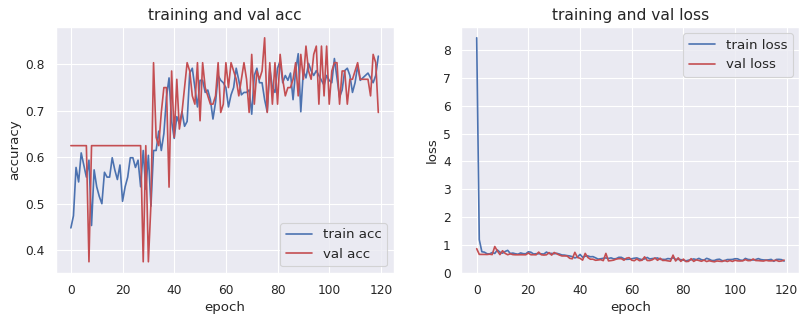

In [5]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [6]:
model_save_path = '/content/drive/MyDrive/crp0.3_checkpoint'
torch.save(model.state_dict(), model_save_path)

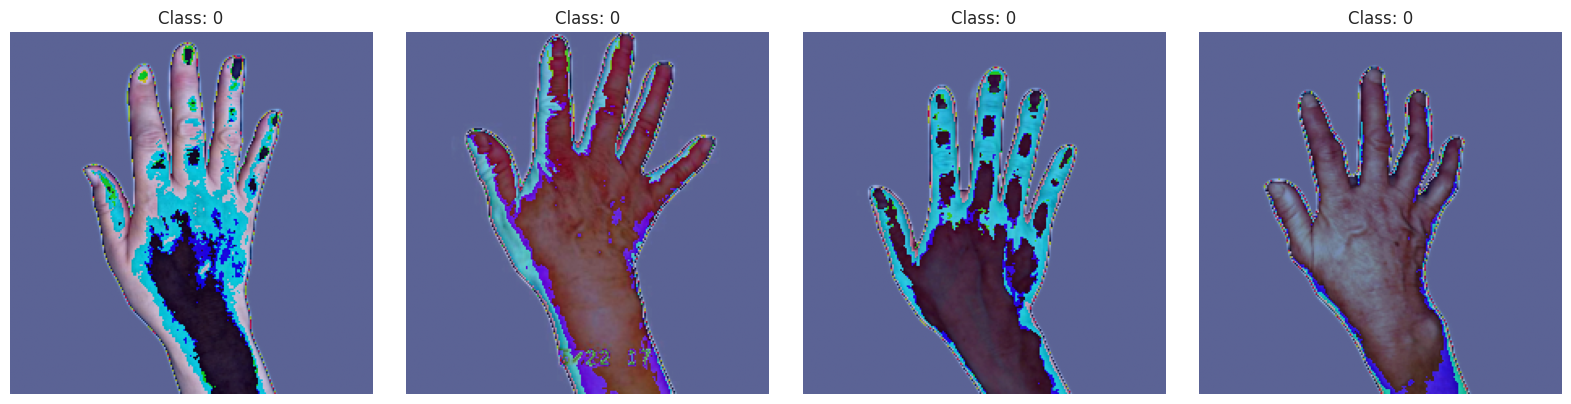

13216

In [17]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # 最後のアテンションブロックを取得
        if hasattr(model, 'blocks'):
            target_layer = model.blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        # 入力をデバイスに移動
        x = x.to(self.device)

        # 予測を実行
        output = self.model(x)
        pred_class = output.argmax(dim=1)

        # 予測クラスに対する勾配を計算
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # 特徴量と勾配の処理
        feature_map = self.feature[:, 1:, :]  # CLSトークンを除外
        gradient_map = self.gradient[:, 1:, :]  # CLS トークンを除外

        # 重みの計算
        weights = gradient_map.mean(dim=2)  # [1, N]

        # CAMの計算
        batch_size = feature_map.shape[0]
        num_patches = feature_map.shape[1]
        patch_size = int(np.sqrt(num_patches))

        cam = torch.mul(feature_map, weights.unsqueeze(-1))
        cam = cam.mean(dim=2)  # [1, N]

        # パッチサイズに変形
        cam = cam.view(batch_size, patch_size, patch_size)

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    # 画像を[0, 255]の範囲に変換
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    # ヒートマップを[0, 255]の範囲に変換してカラーマップを適用
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    # 別のカラーマップを試す（例：COLORMAP_VIRIDISやCOLORMAP_INFERNO）
    #heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)

    # 画像とヒートマップを重ね合わせ
    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# GradCAMのインスタンスを作成
grad_cam = GradCam(model, device)

# テストデータから画像を取得
images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

# ヒートマップの生成と表示
plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        # GradCAMを計算
        heatmap = grad_cam(image.unsqueeze(0))

        # ヒートマップをオーバーレイ
        overlayed = overlay_heatmap_to_image(image, heatmap)

        # 結果を表示
        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {label.item()}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

# メモリの解放
torch.cuda.empty_cache()
gc.collect()